# **Data Pipeline Automation Project**

### **`Project Overview: Event Ticket Management & Real-Time Analytics`**

For this project, I built a Data Pipeline for data extraction, transformation, visualization, and a real-time data monitoring system for an Event Management Company.

A data pipeline and ETL process was developed to monitor ticket sales for a major upcoming event, utilizing an ETL process and real-time visualization to track confirmed, cancelled and refunded tickets.  

Refer to the GitHub README file for detailed project setup, folder structure, technology stack, system architecture and data security protocols                                                                                                                                            

### **`The Business Problem`**

During high-demand ticket sales, data is generated rapidly across multiple payment gateways and support channels. Inconsistent data entry and duplicate registrations often compromise financial integrity, leading to inventory overselling, reconciliation discrepancies, and distorted sales metrics. This project mitigates these risks by providing an automated analytics ecosystem with a 10-minute refresh cycle. It features a fail-safe alerting system for pipeline integrity and a live monitoring feed for ticket sales, empowering key business stakeholders with real-time operational intelligence to support agile, strategic data-driven decision-making

### **`Project Steps`**

#### 1. **`Libraries & Dependencies Requirement Setup`**

In [6]:
# Requirements & Secure Setup
!pip install psycopg2
!pip install pymysql
!pip install pyodbc
!pip install apscheduler                             
!pip install python-dotenv                            
                            

In [7]:
# Import libraries and Dependencies
from apscheduler.schedulers.background import BackgroundScheduler
from IPython.display import display, clear_output
from sqlalchemy import create_engine, text
from datetime import datetime, timedelta
from email.message import EmailMessage
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import seaborn as sns
import pandas as pd
import numpy as np
import smtplib
import logging
import random
import time
import os


In [9]:
# Initialize logging setup and environment variables
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')    # for production-grade documentation

# Created an .env file to encrypt passwords and sensitive entries for cloud DB (Data security)


#### **`2. Established a secure connection to a Cloud PostgreSQL instance (Data Security)`**

In [10]:
# Aiven Database connection configuration

# Load variables from .env (data security)
load_dotenv()

# Retrieve the URI
DB_URI = os.getenv("AIVEN_SERVICE_URI")

if not DB_URI:
    raise ValueError("❌ Database URI not found! Check your .env file.")

# Configure Avien Engine
engine = create_engine(DB_URI, pool_pre_ping=True, pool_recycle=3600)

try:
    with engine.connect() as conn:
        print("✅ Securely connected to Aiven Cloud using Environment Variables!")
except Exception as e:
    print(f"❌ Connection failed: {e}")


✅ Securely connected to Aiven Cloud using Environment Variables!


#### 3. **`Development of Customer Dummy Data `**

In [12]:
# Create dummy customer data for cloud DB (Aiven/PostgreSQL)

# Seed for reproducibility
random.seed(42)

# Create variables for column datapoints
data_list = []
statuses = ['Confirmed', 'Cancelled', 'Refunded', None]
names = ['ALICE JOHNSON', 'bob smith', '  Charlie Brown  ', 'Diana Prince', 'Edward Cullen', 'Fiona Shrek', 'GARY VEE']
emails = ['ALICE@GMAIL.COM', 'bob.s@outlook.com', None, 'diana@amazon.com', 'edward@twilight.com', 'fiona@swamp.com', 'GARY@VEE.COM']

for i in range(20):
    # Logic to create dummy customer data having data quality issues
    row = {
        'customer_id': 100 + (i % 15), 
        'customer_name': random.choice(names),
        'email': random.choice(emails),
        'transaction_id': f'TXN_{1000 + i}',
        'amount': round(random.uniform(-50, 1500), 2),
        'transaction_date': (datetime.now() - timedelta(days=i)).strftime('%Y-%m-%d'),
        'ticket_id': 5000 + i if i % 3 == 0 else None,
        'status': random.choice(statuses) if i % 4 == 0 else None
    }
    data_list.append(row)

# Add a specific row duplicate for testing (data validation)
data_list.append(data_list[0]) 

dirty_df = pd.DataFrame(data_list)
print(f"Generated {len(dirty_df)} rows of dirty data.")
dirty_df


Generated 21 rows of dirty data.


,customer_id,customer_name,email,transaction_id,amount,transaction_date,ticket_id,status
0,100,Fiona Shrek,ALICE@GMAIL.COM,TXN_1000,-11.23,2026-02-13,5000.0,Refunded
1,101,bob smith,bob.s@outlook.com,TXN_1001,166.28,2026-02-12,NaN,None
2,102,ALICE JOHNSON,fiona@swamp.com,TXN_1002,1098.04,2026-02-11,NaN,None
3,103,Edward Cullen,ALICE@GMAIL.COM,TXN_1003,865.26,2026-02-10,5003.0,None
4,104,ALICE JOHNSON,ALICE@GMAIL.COM,TXN_1004,95.23,2026-02-09,NaN,Cancelled
5,105,Edward Cullen,edward@twilight.com,TXN_1005,-8.87,2026-02-08,NaN,None
6,106,bob smith,fiona@swamp.com,TXN_1006,957.32,2026-02-07,5006.0,None
7,107,Edward Cullen,diana@amazon.com,TXN_1007,291.68,2026-02-06,NaN,None
8,108,Edward Cullen,None,TXN_1008,1204.62,2026-02-05,NaN,Confirmed
9,109,GARY VEE,GARY@VEE.COM,TXN_1009,197.47,2026-02-04,5009.0,None


In [13]:
# Push the created dataframe (20 rows) to Aiven/PostgreSQL cloud DB

try:
    dirty_df.to_sql('raw_enterprise_data', engine, if_exists='replace', index=False)
    logging.info("✅ 20 Dirty Rows Seeded to Aiven Cloud.")
    print("🚀 Event management company customer dummy data successfully uploaded to Aiven Cloud SQL!")
except Exception as e:
    print(f"❌ Upload failed: {e}")


2026-02-13 12:32:05,934 - INFO - ✅ 20 Dirty Rows Seeded to Aiven Cloud.


🚀 Event management company customer dummy data successfully uploaded to Aiven Cloud SQL!


#### 4. **`Automated ETL Pipeline Development & Data Cleaning`**

In [15]:
# Create Data pipeline for data extraction and transformation

class EnterpriseDataPipeline:
    def __init__(self, db_engine):
        self.engine = db_engine
        self.raw_df = None
        self.clean_df = None
        self.audit_log = {}

    def extract(self):
        """Extracts the 20 rows of dirty data from the Aiven Cloud postgreSQL table."""
        query = "SELECT * FROM raw_enterprise_data"
        logging.info("Starting extraction from Aiven Cloud postgreSQL...")
        
        try:
            with self.engine.connect() as conn:
                self.raw_df = pd.read_sql(text(query), conn)
            logging.info(f"Extraction successful. {len(self.raw_df)} rows retrieved.")
            return self.raw_df
        except Exception as e:
            logging.error(f"Database extraction failed: {e}")
            raise

    def transform(self):
        """Applies data cleaning to handle the 20 dirty rows."""
        if self.raw_df is None:
            return None
        
        df = self.raw_df.copy()
        
        # 1. Deduplication
        initial_count = len(df)
        df = df.drop_duplicates(subset=['customer_id', 'transaction_id'], keep='first')
        self.audit_log['duplicates_removed'] = initial_count - len(df)

        # 2. String Standardization 
        df['customer_name'] = df['customer_name'].str.strip().str.title()
        df['email'] = df['email'].str.strip().str.lower()

        # 3. Missing Data Imputation
        # Assign placeholder for missing contact info
        df['email'] = df['email'].fillna('no-email@company.com')
        
        # Handling null values: Fill nulls with 'No Ticket'
        df['ticket_id'] = df['ticket_id'].fillna(0).astype(int)
        df['support_status'] = df['status'].fillna('Pending')
        
        # 4. Integrity Checks: Handling Negative Amounts (Refunds)
        df['amount'] = pd.to_numeric(df['amount'], errors='coerce').fillna(0.0)
        df['is_refund'] = df['amount'] < 0

        # 5. Date Normalization
        df['transaction_date'] = pd.to_datetime(df['transaction_date'])

        self.clean_df = df
        logging.info(f"Transformation complete. {self.audit_log['duplicates_removed']} duplicates removed.")
        return self.clean_df

    def run(self):
        """Execution wrapper used by the 10-minute scheduler."""
        self.extract()
        return self.transform()

# Initialize the pipeline with Aiven Cloud Engine
pipeline = EnterpriseDataPipeline(engine)


#### 5. **`Automated Failure Notifications & High-Frequency Transactional Simulation`**

In [17]:
# Email alert monitoring system configuration
SMTP_SERVER = "smtp.gmail.com"
SMTP_PORT = 465
RECIPIENT = "damilolapeter.idowu@gmail.com"

def send_failure_alert(error_message):
    """Sends a professional failure notification via Email."""
    msg = EmailMessage()
    msg.set_content(f"""
    Attention Data Team,

    The Data Pipeline failed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.
    
    ERROR DETAILS:
    {error_message}
    
    The dashboard is currently showing stale data. Please investigate the SQL connection.
    """)
    
    msg['Subject'] = "🚨 CRITICAL: Cloud Pipeline Failure"
    msg['From'] = EMAIL_USER
    msg['To'] = RECIPIENT

    try:
        with smtplib.SMTP_SSL(SMTP_SERVER, SMTP_PORT) as server:
            server.login(os.getenv("EMAIL_USER"), os.getenv("EMAIL_PASS"))
            server.send_message(msg)
        logging.info("Alert email sent successfully.")
    except Exception as e:
        logging.error(f"Failed to send email alert: {e}")


In [18]:
# Simulate customer real-time traffic for ticket purchase

def simulate_realtime_traffic(iterations=10):
    """Adds a new row to the Cloud postgreSQL DB every minute."""
    print("Starting Live Traffic Simulation...")
    for i in range(iterations):
        new_row = pd.DataFrame([{
            'customer_id': random.randint(100, 120),
            'customer_name': 'New Customer ' + str(i),
            'email': 'new.user@cloud.com',
            'transaction_id': f'LIVE_{random.randint(999, 9999)}',
            'amount': round(random.uniform(10, 500), 2),
            'transaction_date': datetime.now().strftime('%Y-%m-%d'),
            'ticket_id': random.randint(6000, 7000),
            'status': random.choice(statuses) if i % 4 == 0 else None
        }])
        
        # 'append' mode adds data without deleting the existing 20 rows
        new_row.to_sql('raw_enterprise_data', engine, if_exists='append', index=False)
        logging.info("➕ Live row added to Aiven Cloud postgreSQL DB.")
        print(f"Inserted live row {i+1}/{iterations} at {datetime.now().strftime('%H:%M:%S')}")
        #time.sleep(60)


#### 6. **`Automated Data Refresh and Real-time Monitoring Configuration`**

In [20]:
# Define function to automate the data source refresh operation 

# Create global variable to hold the most recent 'Clean' version of the data
latest_clean_df = pd.DataFrame()

def refresh_task():
    """
    Function to be executed every 10 minutes.
    It pulls from SQL, cleans the data and updates the global variable.
    """
    global latest_clean_df

    logging.info("--- Periodic Refresh Started ---")
    try:
        # Run data pipeline
        latest_clean_df = pipeline.run()
        logging.info("♻️ Pipeline refresh completed.")
        
        # Print a small log to the Jupyter console for confirmation
        print(f"--- Pipeline Heartbeat: {datetime.now().strftime('%H:%M:%S')} ---")
        print(f"Current Row Count: {len(latest_clean_df)}")
        print(f"Total Revenue: ${latest_clean_df['amount'].sum():,.2f}")
    except Exception as e:
        send_failure_alert(str(e))

# Initialize and start the scheduler
scheduler = BackgroundScheduler()
scheduler.add_job(refresh_task, 'interval', minutes=10, id='enterprise_refresh_id') # Data refresh
scheduler.add_job(simulate_realtime_traffic, 'interval', minutes=1) # Traffic feed
scheduler.start()

# Call function to create refreshed-cleaned customer data
refresh_task()


2026-02-13 12:32:06,100 - INFO - Adding job tentatively -- it will be properly scheduled when the scheduler starts
2026-02-13 12:32:06,103 - INFO - Adding job tentatively -- it will be properly scheduled when the scheduler starts
2026-02-13 12:32:06,103 - INFO - Added job "refresh_task" to job store "default"
2026-02-13 12:32:06,103 - INFO - Added job "simulate_realtime_traffic" to job store "default"
2026-02-13 12:32:06,105 - INFO - Scheduler started
2026-02-13 12:32:06,108 - INFO - --- Periodic Refresh Started ---
2026-02-13 12:32:06,109 - INFO - Starting extraction from Aiven Cloud postgreSQL...
2026-02-13 12:32:07,338 - INFO - Extraction successful. 21 rows retrieved.
2026-02-13 12:32:07,435 - INFO - Transformation complete. 1 duplicates removed.
2026-02-13 12:32:07,437 - INFO - ♻️ Pipeline refresh completed.


--- Pipeline Heartbeat: 12:32:07 ---
Current Row Count: 20
Total Revenue: $12,125.77


#### 7. **`Data Validation`**

In [22]:
# Data integrity validation
# Compare Raw vs Clean customer data by a sample

sample_id = 102
print("RAW DATA SAMPLE:")
display(pipeline.raw_df[pipeline.raw_df['customer_id'] == sample_id].head(1))

print("\nCLEANED DATA SAMPLE:")
display(latest_clean_df[latest_clean_df['customer_id'] == sample_id].head(1))

RAW DATA SAMPLE:


,customer_id,customer_name,email,transaction_id,amount,transaction_date,ticket_id,status
2,102,ALICE JOHNSON,fiona@swamp.com,TXN_1002,1098.04,2026-02-11,NaN,None



CLEANED DATA SAMPLE:


,customer_id,customer_name,email,transaction_id,amount,transaction_date,ticket_id,status,support_status,is_refund
2,102,Alice Johnson,fiona@swamp.com,TXN_1002,1098.04,2026-02-11,0,None,Pending,False


#### 8. **`Data Visualization & Real-time traffic monitoring`**

C:\Users\DAMILOLA\AppData\Local\Temp\ipykernel_23192\2232587161.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=latest_clean_df, x='support_status',
2026-02-13 12:41:18,141 - INFO - ➕ Live row added to Aiven Cloud postgreSQL DB.


Inserted live row 8/10 at 12:41:18


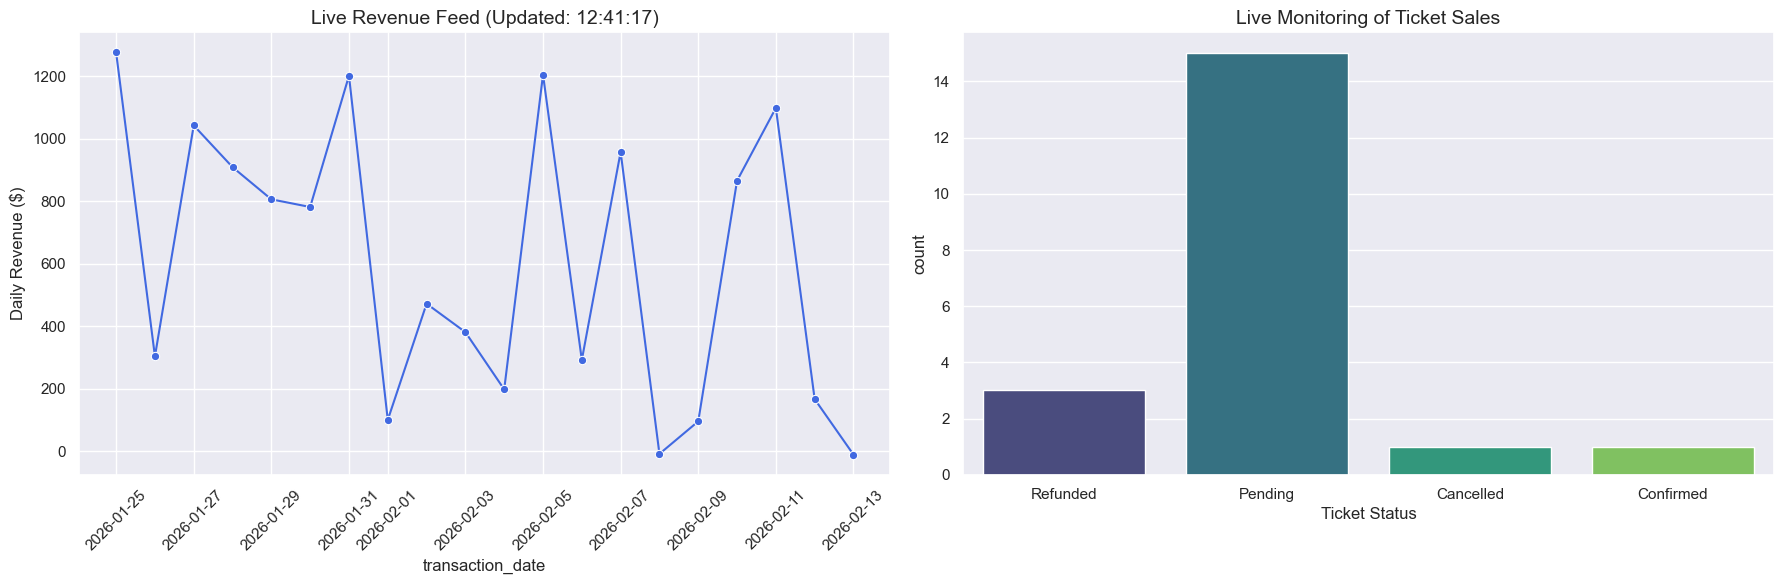

2026-02-13 12:41:19,671 - INFO - ➕ Live row added to Aiven Cloud postgreSQL DB.


Inserted live row 9/10 at 12:41:19


2026-02-13 12:41:21,144 - INFO - ➕ Live row added to Aiven Cloud postgreSQL DB.
2026-02-13 12:41:21,145 - INFO - Job "simulate_realtime_traffic (trigger: interval[0:01:00], next run at: 2026-02-13 12:42:06 WAT)" executed successfully


Inserted live row 10/10 at 12:41:21


In [ ]:
# Visualization of real-time traffic simulation

def run_live_dashboard():
    """Continuously updates the dashboard with the latest cleaned data."""
    try:
        while True:
            if latest_clean_df.empty:
                print("Waiting for initial data load...")
                time.sleep(5)
                continue

            # Clear the previous output for the 'Real-Time' feed
            clear_output(wait=True)
            
            # Setup Figure
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
            sns.set_theme(style="darkgrid")

            # Chart 1: Revenue Over Time Trend
            trend_df = latest_clean_df.groupby('transaction_date')['amount'].sum().reset_index()
            sns.lineplot(data=trend_df, x='transaction_date', y='amount', 
                         marker='o', color='royalblue', ax=ax1)
            ax1.set_title(f"Live Revenue Feed (Updated: {datetime.now().strftime('%H:%M:%S')})", fontsize=14)
            ax1.set_ylabel("Daily Revenue ($)")
            ax1.tick_params(axis='x', rotation=45)

            # Chart 2: Support Ticket Status (Operational Feed)
            sns.countplot(data=latest_clean_df, x='support_status', 
                          palette='viridis', ax=ax2)
            ax2.set_title("Live Monitoring of Ticket Sales", fontsize=14)
            ax2.set_xlabel("Ticket Status")

            plt.tight_layout()
            display(fig)
            plt.close(fig)

            # Check every 60 seconds for data updates
            time.sleep(60)
            
    except KeyboardInterrupt:
        print("Dashboard stopped.")

# View the dashboard
run_live_dashboard() 
